In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

# Synthetic data

In [2]:
X1 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y1 = 1. + 1. * X1.reshape(-1) + 1.*numpy.random.rand(len(X1))

X2 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y2 = -4.5 + 3. * X2.reshape(-1) + 1.*numpy.random.rand(len(X2))

X3 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y3 = 4.5 + -1. * X2.reshape(-1) + 1.*numpy.random.rand(len(X2))

X = numpy.concatenate((X1, X2, X3), axis=0) 
y = numpy.concatenate((y1, y2, y3), axis=0)

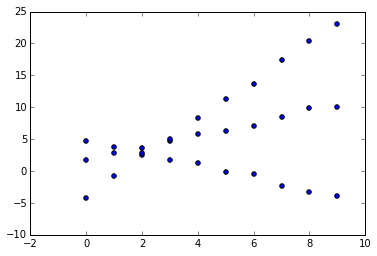

In [3]:
plt.scatter(X, y)
plt.show()

In [4]:
#%%px

import numpy
import pandas
from sklearn.linear_model import LinearRegression
import itertools, random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


class JustLinearRegression(object):

    def __init__(self):

        self.regressor = None # regressor's class

    def fit(self, X, y):

        qlr = LinearRegression()
        qlr.fit(X, y)

        self.regressor = qlr

        if len(X) > 2:
            score = numpy.sqrt(1. * (numpy.abs(qlr.predict(X) - y)**2).sum() / (len(X) - 2))
        else:
            score = numpy.sqrt(1. * (numpy.abs(qlr.predict(X) - y)**2).sum() / (len(X) - 1))

        return score, qlr


    def predict(self, X):

        return self.regressor.predict(X)


class MultiLinearRegression(object):

    def __init__(self, n_tracks, 
                 n=4, 
                 subsample=1., 
                 x_unique=True, 
                 n_neighbors=10, 
                 step=0.05,  
                 track_classifier=None,
                 hit_classifier=None):

        self.n = n
        self.subsample = subsample
        self.x_unique = x_unique
        self.n_neighbors = n_neighbors
        self.step = step
        self.n_tracks = n_tracks
        self.track_classifier = track_classifier
        self.hit_classifier = hit_classifier
        self.unique_sorted_dists = []
        self.unique_sorted_indeces = []


    def get_index_combinations(self, X, n):

        index_combinations = []

        indeces = range(len(X))
        random.seed = 42

        for one_combination in itertools.combinations(indeces, n):
            
            if self.subsample >= random.random():

                if self.x_unique:

                    X_one = X[list(one_combination)]
                    X_one_unique = numpy.unique(X_one)

                    if len(X_one_unique) == n:

                        index_combinations.append(list(one_combination))

                else:

                    index_combinations.append(list(one_combination))

        return index_combinations



    def fit_lines(self, X, y):

        scores_list = []
        lrs_list = []

        indexes_list = self.get_index_combinations(X, self.n)

        for ind in indexes_list:

            ind = list(ind)

            X_step = X[ind]
            y_step = y[ind]

            mlr = JustLinearRegression()
            score, lr = mlr.fit(X_step, y_step)
            
            scores_list.append(score)
            lrs_list.append(lr)

        return numpy.array(scores_list), numpy.array(lrs_list), numpy.array(indexes_list)
    
    def knn_max_density(self, X, n_neighbors, step):

        ss = StandardScaler()
        ss.fit(X)
        X_standart = ss.transform(X)

        passed_points_indeces = range(len(X_standart))
        X_passed_standart = X_standart

        while len(X_passed_standart) > n_neighbors:

            knn = NearestNeighbors(n_neighbors=n_neighbors, leaf_size=100)
            knn.fit(X_passed_standart)
            knn_dists, knn_indeces = knn.kneighbors()

            knn_dists_mean = knn_dists.mean(axis=1)

            n_points = max(1, int(step * len(X_passed_standart)))
            passed_points_indeces = knn_dists_mean.argsort()[:-n_points]
            knn_dists_mean.sort()

            X_passed_standart = X_passed_standart[passed_points_indeces]
            
        X_passed = ss.inverse_transform(X_passed_standart)

        return X_passed


    def get_tracks(self, X, n_tracks):

        ss = StandardScaler()
        ss.fit(X)

        transformed_tracks = ss.transform(X).mean(axis=0)
        tracks = ss.inverse_transform(transformed_tracks)
            
        return tracks
    
    def _select_array(self, array):

        max_model = None
        max_score = -1

        for n_clusters in [2, 3, 4]:

            km = KMeans(n_clusters=3)
            km.fit(array.reshape(-1, 1))

            score = silhouette_score(array.reshape(-1, 1), km.labels_)

            if score > max_score:

                max_score  = score
                max_model = km


        if max_score >= 0.7:

            min_cluster_id = max_model.cluster_centers_.reshape(-1).argsort()[0]
            indeces = numpy.arange(len(array))[max_model.labels_ == min_cluster_id]

        else:

            indeces = numpy.arange(len(array))
                
        return indeces
    
    def _hits_classification(self, dists, track):
        
        ks = [[track[0]]] * len(dists)
        bs = [[track[1]]] * len(dists)
        
        X = numpy.concatenate((dists.reshape(-1,1), ks, bs), axis=1)
        predict = self.hit_classifier.predict(X)
        
        return numpy.arange(len(dists))[predict == 1]
    
    def get_points(self, X, y, track):
        
        dists = numpy.abs(y - (track[:-1] * X).sum(axis=1) - track[-1])
        sorted_dists_indeces = dists.argsort()
        
        indeces = numpy.array(range(len(X)))

        sorted_dists = dists[sorted_dists_indeces]
        sorted_X = X[sorted_dists_indeces]
        sorted_y = y[sorted_dists_indeces]
        sorted_indeces = indeces[sorted_dists_indeces]

        unique, index = numpy.unique(sorted_X, return_index=True)

        unique_dists = sorted_dists[index]
        unique_X = sorted_X[index]
        unique_y = sorted_y[index]
        unique_indeces = sorted_indeces[index]

        sorted_dists_indeces = unique_dists.argsort()

        unique_sorted_dists = unique_dists[sorted_dists_indeces]
        unique_sorted_X = unique_X[sorted_dists_indeces]
        unique_sorted_y = unique_y[sorted_dists_indeces]
        unique_sorted_indeces = unique_indeces[sorted_dists_indeces]
        
        self.unique_sorted_dists.append(unique_sorted_dists)
        self.unique_sorted_indeces.append(unique_sorted_indeces)
        
        if self.hit_classifier == None:
        
            track_indeces = self._select_array(unique_sorted_dists)
            
        else:
            
            track_indeces = self._hits_classification(unique_sorted_dists, track)
        
        return unique_sorted_X[track_indeces], unique_sorted_y[track_indeces], unique_sorted_indeces[track_indeces]
        
        
        
    def _fit_satellite(self, scores, lrs):
        
        ks = numpy.array([lr.coef_ for lr in lrs])
        bs = numpy.array([lr.intercept_ for lr in lrs]).reshape((-1,1))
        
        track_candidates = numpy.concatenate((ks, bs), axis=1)
        
        n_neighbors = self.n_neighbors
        step = self.step
        track_candidates_dense = self.knn_max_density(track_candidates, n_neighbors, step)
        
        
        tracks = self.get_tracks(track_candidates_dense, self.n_tracks)
        
        return tracks
    
    def _classification(self, scores, lrs, indeces):
        
        ks = numpy.array([lr.coef_ for lr in lrs])
        bs = numpy.array([lr.intercept_ for lr in lrs]).reshape((-1,1))
        
        X = numpy.concatenate((scores.reshape(-1,1), ks, bs.reshape(-1,1)), axis=1)
        y_predict = self.track_classifier.predict(X)
        
        return scores[y_predict == 1], lrs[y_predict == 1], indeces[y_predict == 1]
    
    def _isAinB(self, A, B):
    
        return len(set(A) & set(B)) != 0
    
    def _get_all_tracks(self, X, y, scores, lrs, indeces, unique_index):
        
        tracks = []
        tracks_labels = -1 * numpy.ones(len(X))
        
        self.qw = []
        
        if unique_index == None:
            
            scores_curr = scores.copy()
            lrs_curr = lrs.copy()
            looked_inds = []
            
            for num in range(self.n_tracks):
                
                one_track = self._fit_satellite(scores_curr, lrs_curr)
                one_track_X, one_track_y, one_track_indeces = self.get_points(X, y, one_track)
                tracks_labels[one_track_indeces] = num
                tracks.append(one_track)
                
                self.qw.append(one_track_indeces)
                
                looked_inds += list(one_track_indeces)
                
                selection = numpy.array([not self._isAinB(i, looked_inds) for i in indeces])
                scores_curr = scores[selection]
                lrs_curr = lrs[selection]
                
        return tracks, tracks_labels
                
    
    def fit(self, X, y, unique_index=None):
        
        scores, lrs, indeces = self.fit_lines(X, y)
        
        if self.track_classifier != None:
            
            scores, lrs, indeces = self._classification(scores, lrs, indeces)
            self.scores_ = scores
            self.lrs_ = lrs
            self.indeces_ = indeces
        
            tracks, tracks_labels = self._get_all_tracks(X, y, scores, lrs, indeces, unique_index)
        
        else:
            
            self.scores_ = scores
            self.lrs_ = lrs
            self.indeces_ = indeces
        
            tracks, tracks_labels = self._get_all_tracks(X, y, scores, lrs, indeces, unique_index)
            
        
        self.tracks_ = tracks
        self.labels_ = tracks_labels


    def predict(self, X):
        
        predictions = []
        
        for track in self.tracks_:
            
            y_predict = (track[:-1] * X).sum(axis=1) + track[-1]
            predictions.append(y_predict)
            
        return numpy.array(predictions)

In [5]:
%%time
rmlr = MultiLinearRegression(n_tracks=3, 
                             n=3, 
                             subsample=1, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=None)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    #plt.scatter(X[rmlr.qw[num]], y[rmlr.qw[num]], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'classifier'

In [ ]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

In [ ]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 5), numpy.percentile(a, 95)], 
                                 [numpy.percentile(b, 5), numpy.percentile(b, 95)]])
plt.colorbar()
plt.show()

# SHiP

In [10]:
import os, sys
sys.path.append('../functions')
from Y_views import *
import cPickle as pickle

all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'rb')
reconstructible_events_valid_pkl = pickle.load(file_pickle)
file_pickle.close()
reconstructible_events_valid = reconstructible_events_valid_pkl

In [11]:
from Y_views import *
from UV_views import *

hits_zy_12, _ = modify_for_yz_analysis_1_2(all_hits)
hits_zx_12, _ = modify_for_xz_analysis_1_2(all_hits)

hits_zy_34, _ = modify_for_yz_analysis_3_4(all_hits)
hits_zx_34, _ = modify_for_xz_analysis_3_4(all_hits)

In [12]:
event_id =  1967#381#518#1756#27
event = hits_zy_12[hits_zy_12['event'] == event_id]

In [13]:
XX = event.Wz.values
yy = event.Wy.values
rr = 1*event.dist2Wire.values

X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
y = numpy.concatenate((yy+rr, yy-rr), axis=0) 

In [14]:
%%time
rmlr = MultiLinearRegression(n_tracks=2, 
                             n=3, 
                             subsample=0.5, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=None)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'classifier'

In [ ]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

In [ ]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 1), numpy.percentile(a, 99)], 
                                 [numpy.percentile(b, 1), numpy.percentile(b, 99)]])
plt.colorbar()
plt.show()

# SHiP + Classifier

In [ ]:
def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits

In [15]:
from sklearn.linear_model import LinearRegression

def get_data_zx_classifier(hits_zy, hits_zx, events, stations):

    data_zx_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zx_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values

        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits[stereo_hits.TrackID == 2].Z.values.reshape(-1, 1)
        stereo_y = stereo_hits[stereo_hits.TrackID == 2].X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits[stereo_hits.TrackID == 3].Z.values.reshape(-1, 1)
        stereo_y = stereo_hits[stereo_hits.TrackID == 3].X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zx_track, data_zx_hit

In [16]:
data_zx_track, data_zx_hit = get_data_zx_classifier(hits_zy_12, 
                                                    hits_zx_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

In [17]:
data_zx_track.head()

,score,k,b,label
0,0.000136,-0.017763,70.207968,1
1,0.000072,0.022757,86.860768,1
2,66.578040,0.033206,-7.707405,0
3,66.578040,0.033206,-7.707405,0
4,0.000028,-0.009071,-87.588542,1


In [18]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data_zx_track[['score', 'k', 'b']].values
y_data = data_zx_track[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
track_clf_zx = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time track_clf_zx.fit(X_data, y_data)

CPU times: user 162 ms, sys: 191 ms, total: 353 ms
Wall time: 245 ms


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=2,
         parallel_profile=None, random_state=11)

In [19]:
data_zx_hit.head()

,dist,k,b,label
0,121.647606,-0.017763,70.207968,0
1,0.000202,-0.017763,70.207968,1
2,0.000136,-0.017763,70.207968,1
3,121.797284,-0.017763,70.207968,0
4,0.000094,-0.017763,70.207968,1


In [20]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data_zx_hit[['dist', 'k', 'b']].values
y_data = data_zx_hit[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
hit_clf_zx = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time hit_clf_zx.fit(X_data, y_data)

CPU times: user 952 ms, sys: 305 ms, total: 1.26 s
Wall time: 771 ms


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=2,
         parallel_profile=None, random_state=11)

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_data, track_clf_zx.predict(X_data))

KFold prediction using random classifier (length of data passed not equal to length of train)


0.99864025452074667

In [22]:
from sklearn.linear_model import LinearRegression

def get_data_zy_classifier(hits_zy, events, stations):

    data_zy_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zy_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values


        X = event.Z.values.reshape(-1, 1)
        y = event.Y.values


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zy_track, data_zy_hit

In [23]:
data_zy_track, data_zy_hit = get_data_zy_classifier(hits_zy_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

In [24]:
data_zy_track.head()

,score,k,b,label
0,0.017528,0.010169,-44.882377,1
1,0.009373,-0.012570,-43.579617,1
2,27.534872,-8.621249,22222.091037,0
3,28.654211,-7.170048,18474.896222,0
4,0.004538,-0.012518,-44.886846,1


In [25]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data_zy_track[['score', 'k', 'b']].values
y_data = data_zy_track[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
track_clf_zy = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time track_clf_zy.fit(X_data, y_data)

CPU times: user 181 ms, sys: 218 ms, total: 399 ms
Wall time: 287 ms


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=2,
         parallel_profile=None, random_state=11)

In [26]:
data_zy_hit.head()

,dist,k,b,label
0,0.015114,0.010169,-44.882377,1
1,57.423647,0.010169,-44.882377,0
2,0.012635,0.010169,-44.882377,1
3,57.481678,0.010169,-44.882377,0
4,58.068569,0.010169,-44.882377,0


In [27]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data_zy_hit[['dist', 'k', 'b']].values
y_data = data_zy_hit[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
hit_clf_zy = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time hit_clf_zy.fit(X_data, y_data)

CPU times: user 1.14 s, sys: 387 ms, total: 1.52 s
Wall time: 1e+03 ms


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=2,
         parallel_profile=None, random_state=11)

In [28]:
event_id =  513#381#518#1756#27
event = hits_zy_12[hits_zy_12['event'] == event_id]

In [29]:
XX = event.Wz.values
yy = event.Wy.values
rr = 1*event.dist2Wire.values

X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
y = numpy.concatenate((yy+rr, yy-rr), axis=0) 

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


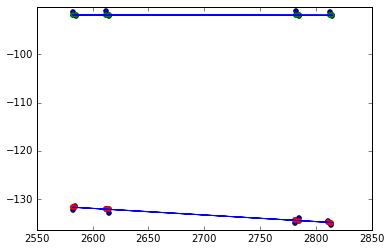

CPU times: user 858 ms, sys: 10.8 ms, total: 869 ms
Wall time: 864 ms


In [30]:
%%time
rmlr = MultiLinearRegression(n_tracks=2, 
                             n=3, 
                             subsample=0.5, 
                             n_neighbors=10, 
                             step=0.1,  
                             track_classifier=track_clf_zy,
                             hit_classifier=hit_clf_zy)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

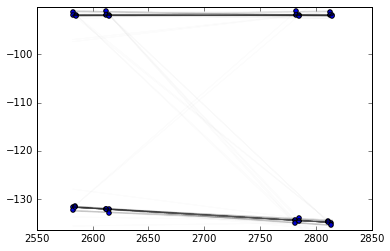

In [31]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

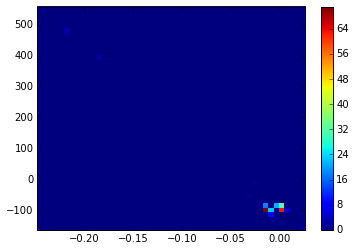

CPU times: user 238 ms, sys: 6.57 ms, total: 245 ms
Wall time: 249 ms


In [32]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 1), numpy.percentile(a, 99)], 
                                 [numpy.percentile(b, 1), numpy.percentile(b, 99)]])
plt.colorbar()
plt.show()

# Tracks Plots

In [33]:
#%%px
#from MultiLinearRegression import MultiLinearRegression

def get_zy_candidates(event_id, data):
    
    event = data[data['event'] == event_id]
    
    n = 3
    if len(event) > 40:
        n = 3

    XX = event.Wz.values
    yy = event.Wy.values
    rr = 1*event.dist2Wire.values
    ii = event.index.values

    X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
    y = numpy.concatenate((yy+rr, yy-rr), axis=0)
    indeces = numpy.concatenate((ii, ii), axis=0)

    rmlr = MultiLinearRegression(n_tracks=2, 
                                 n=n, 
                                 subsample=1, 
                                 n_neighbors=10, 
                                 step=0.1,
                                 track_classifier=None, #track_clf_zy,
                                 hit_classifier=hit_clf_zy)
    rmlr.fit(X, y)
    predictions = rmlr.predict(X)
    
    tracks = rmlr.tracks_
    tracks_labels = rmlr.labels_
    
    
    plt.scatter(XX, yy)
    plt.errorbar(XX, yy, rr, fmt='none', elinewidth=2, capsize=0, capthick=0)
    colors = ['r', 'g', 'm']
    for num, track in enumerate(tracks):
        plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
        plt.plot(X, predictions[num], color='b')

    plt.ylim(y.min()-1, y.max()+1)
    plt.title('Y-view')
    plt.show()

    tracks_yz = {}
    linking_table_yz = {}

    for num, track in enumerate(tracks):
        tracks_yz[num + 1] = track
        linking_table_yz[num + 1] = numpy.unique(indeces[tracks_labels == num])
        
    return tracks_yz, linking_table_yz

def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits[numpy.abs(stereo_hits.Wx.values) < 300]


def get_zx_candidates(event_id, tracks_yz, tracks_cov_yz, data):

    tracks_xz = {}
    linking_table_xz = {}

    for num, track_id in enumerate(tracks_yz.keys()):

        zy_plane_k, zy_plane_b = tracks_yz[track_id]
        cov = tracks_cov_yz[track_id]

        hits = get_zx_hits(event_id, data, zy_plane_k, zy_plane_b)

        XX = hits.Wz.values
        yy = hits.Wx.values
        rr = 1*hits.dist2Wire.values / numpy.sin(10. * numpy.pi / 360.)
        ii = hits.index.values

        X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
        y = numpy.concatenate((yy+rr, yy-rr), axis=0)
        indeces = numpy.concatenate((ii, ii), axis=0)
        
        rmlr = MultiLinearRegression(n_tracks=1, 
                                 n=3, 
                                 subsample=1, 
                                 n_neighbors=10, 
                                 step=0.1,
                                 track_classifier=None, #track_clf_zx,
                                 hit_classifier=hit_clf_zx)
        rmlr.fit(X, y)
        predictions = rmlr.predict(X)

        tracks = rmlr.tracks_
        tracks_labels = rmlr.labels_
        
        stereo_hits = data[data['event'] == event_id]
        plt.scatter(stereo_hits.Z.values, stereo_hits.X.values, color='0.5')
        plt.scatter(stereo_hits.Z.values[numpy.abs(stereo_hits['PdgCode'].values) == 13], 
                    stereo_hits.X.values[numpy.abs(stereo_hits['PdgCode'].values) == 13], color='gold')
        plt.scatter(stereo_hits.Z.values[numpy.abs(stereo_hits['PdgCode'].values) == 211], 
                    stereo_hits.X.values[numpy.abs(stereo_hits['PdgCode'].values) == 211], color='gold')
        
        plt.scatter(XX, yy)
        plt.errorbar(XX, yy, rr, fmt='none', elinewidth=2, capsize=0, capthick=0, ecolor='b')
        colors = ['r', 'g', 'm']
        for num, track in enumerate(tracks):
            plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
            plt.plot(X, predictions[num], color='b')

        #plt.ylim(y.min()-1, y.max()+1)
        plt.ylim(stereo_hits.X.values.min()-2, stereo_hits.X.values.max()+2)
        plt.title('Stereo-view')
        plt.show()

        linking_table_xz[10001 * (num+1)] = list(numpy.unique(indeces[tracks_labels == 0]))
        tracks_xz[10001 * (num+1)] = tracks[0]

    return tracks_xz, linking_table_xz

def run_stations(event_id, data_zy, data_zx):

    reco_events12 = {}

    tracks_yz, linking_table_yz = get_zy_candidates(event_id, data_zy)
    tracks_xz, linking_table_xz = get_zx_candidates(event_id, tracks_yz, linking_table_yz, data_zx)

    reco = [tracks_yz, linking_table_yz, tracks_xz, linking_table_xz]

    reco_events12[event_id] = reco

    #print event_id

    return reco_events12

def merge_dicts(dicts):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dicts:
        result.update(dictionary)
    return result

513  :
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


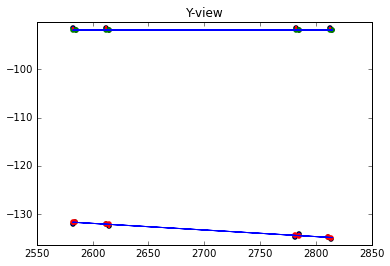

KFold prediction using random classifier (length of data passed not equal to length of train)


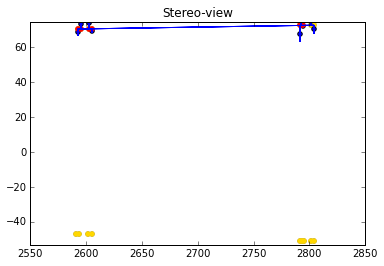

KFold prediction using random classifier (length of data passed not equal to length of train)


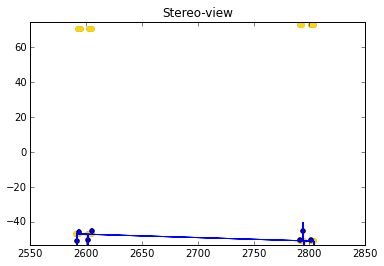

10  :
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


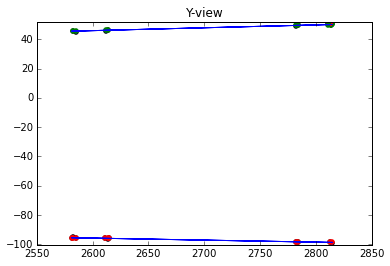

KFold prediction using random classifier (length of data passed not equal to length of train)


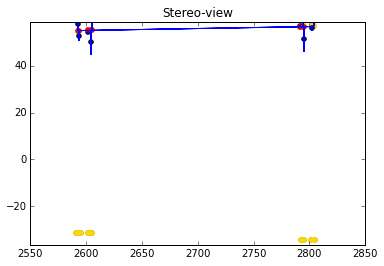

KFold prediction using random classifier (length of data passed not equal to length of train)


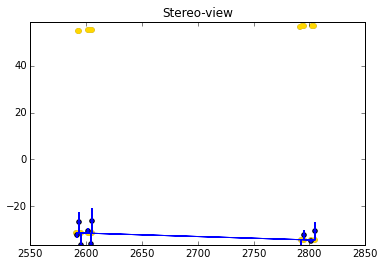

1057  :
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


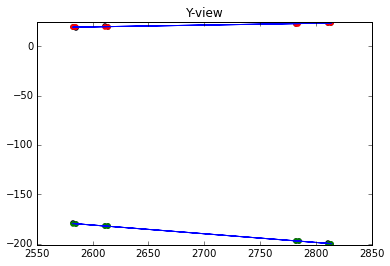

KFold prediction using random classifier (length of data passed not equal to length of train)


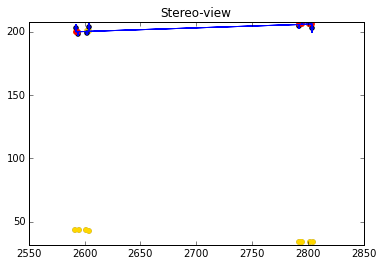

KFold prediction using random classifier (length of data passed not equal to length of train)


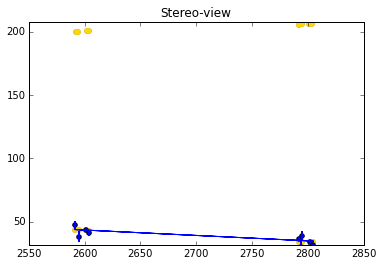

1066  :
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


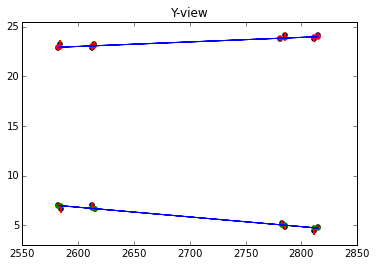

KFold prediction using random classifier (length of data passed not equal to length of train)


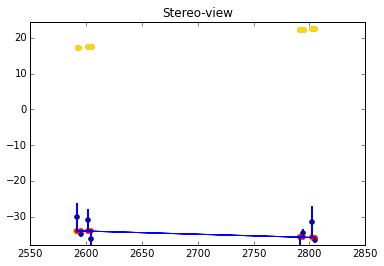

KFold prediction using random classifier (length of data passed not equal to length of train)


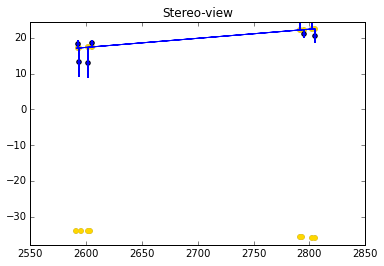

In [34]:
event_set1 = [1057, 2040, 1204, 2263, 2305, 2295, 1793, 102]
event_set2 = [143, 670, 1722, 270, 426, 1528, 1541, 692]
event_set3 = [2040, 1204, 2305, 381, 2263, 1793, 102, 143, 670, 1722, 1265, 270, 1528, 27, 692, 426, 1756]
event_set4 = [513, 10, 1057, 1066]
for event_id in event_set4:
    print event_id, ' :'
    _ = run_stations(event_id, hits_zy_12, hits_zx_12)